# Computer vision and construction of the map

Some importation useful for image processing

In [1]:
import cv2
import time

import numpy as np

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets


Loading and display the image that will be used

Image Loaded


<IPython.core.display.Javascript object>


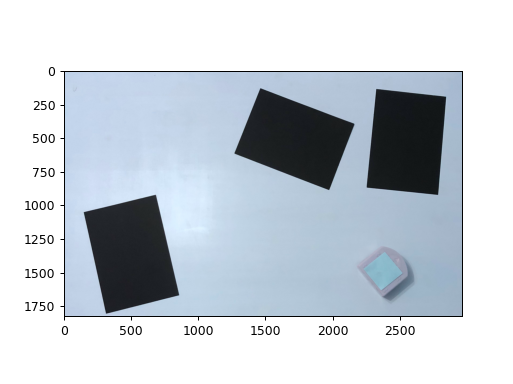

In [2]:
img = cv2.imread('images/corner_detection_thymio3.jpg', cv2.IMREAD_COLOR)

# If the image path is wrong, the resulting img will be none
if img is None:
    print('Open Error')
else:
    print('Image Loaded')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Corner detection with the Shi-Tomasi method

Corner detection using the Shi-Tomasi method
Some remarques for the algo to work :
- See the Thymio from above (otherwise black part will be take into account)
- Black obstacles on a white background
- Play with parameters of Shi-Tomasi funciton if problems
- Filtering and thresholding maybe not necessarily useful

In [3]:
img_copy = img.copy()

#Rescaling the image to be seen in the screen
scale_resize = 0.5
h = img.shape[0]
w = img.shape[1]
h_resize = int(scale_resize*h)
w_resize = int(scale_resize*w)
imS = cv2.resize(img, (w_resize,h_resize))

#Show the original image
cv2.imshow("Original Image", imS)
cv2.waitKey(0)
cv2.destroyAllWindows()

#Blurring with Gaussian to reduce noise - Maybe not necessary, see image with camera
treated = cv2.GaussianBlur(img,(5,5),0)

#Show the treated image
treatedS = cv2.resize(treated, (w_resize,h_resize))
cv2.imshow("Blur image", treatedS)
cv2.waitKey(0)
cv2.destroyAllWindows()

#Convert to grayscale
gray = cv2.cvtColor(treated,cv2.COLOR_BGR2GRAY)
grayS = cv2.resize(gray, (w_resize,h_resize))
cv2.imshow("Gray Image", grayS)
cv2.waitKey(0)
cv2.destroyAllWindows()


#Thresholding if necessary

#No threshold
thresh_image = gray;


#Binary threshold
#thres,thresh_image = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
#thresh_image = cv2.cvtColor(thresh_image,cv2.COLOR_BGR2GRAY)

#Adaptive mean thresholding
#thresh_image = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
#            cv2.THRESH_BINARY,3,2)
#thresh_imageS = cv2.resize(thresh_image, (1920, 1080))

#Adaptive gaussian thresholding
#thresh_image = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#            cv2.THRESH_BINARY,101,4)
#thresh_imageS = cv2.resize(thresh_image, (1920, 1080))


#Show thresholding version
thresh_imageS = cv2.resize(thresh_image, (w_resize,h_resize))
cv2.imshow("Thresh image", thresh_imageS)
cv2.waitKey(0)
cv2.destroyAllWindows()

#Shi-Tomasi method - Play with the parameters depending on the image

maxCorners = 0 #Return all the corners detected
qualityLevel = 0.2 #Level of quality of corner desired - to avoid detect false corners
minDistance = 200 #Minimum Euclidean distance between two corners - assume a certain size of the obstacles
corners = cv2.goodFeaturesToTrack(thresh_image, maxCorners, qualityLevel, minDistance)

#Draw red circle on the corners
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv2.circle(img_copy,(x,y),10,(0,0,255),-1)
img_copyS = cv2.resize(img_copy, (w_resize,h_resize))

            
#Show the result
cv2.imshow("After corner detection", img_copyS)
cv2.waitKey(0)
cv2.destroyAllWindows()


We can verify the list of corners

In [4]:
#List containing the coordinates of the corners - To use it later
print(corners)
print(len(corners))

[[[2326  142]]

 [[2844  199]]

 [[1973  890]]

 [[2784  926]]

 [[ 148 1057]]

 [[ 314 1809]]

 [[ 856 1672]]

 [[1463  137]]

 [[2256  872]]

 [[ 683  928]]

 [[1270  618]]

 [[2160  401]]]
12
<class 'numpy.ndarray'>


## Obstacles and free path


From the list of corners, by verifying the value of the pixels, we can find where are the obstacles and the free paths. 
We will latter increase the size of the obstacles
We will use the free paths for the global navigation algorithm

Function to compute a line between two points with the color depending on the value of the pixel :
- If pixel inside an obstacle (small value), mark in red
- If pixel outside an obstacle (big value), mark in green


In [5]:
#Function to compute line between the corners and with the color depending on the value of the pixels 
def compute_line(x1,y1, x2, y2, img) :
    img2_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    pt_a = np.array([x1, y1])
    pt_b = np.array([x2, y2])
    count_red = 0
    count_green = 0
    for p in np.linspace(pt_a, pt_b, 50):
        x,y = p.ravel()
        x = int(x)
        y = int(y)
        if img2_gray[y,x] < 100 :
            cv2.circle(img, (x,y), 10, (0, 0, 255), -1)
            count_red += 1
        else :
            cv2.circle(img, (x,y), 10, (0, 255, 0), -1)
            count_green += 1
        
    return count_red, count_green

Draw a line between each corner
The obstacles (small value) are marked in red
The free path (big value) are marked in green
By counting the number of element of a line which are green or red, we can determine if the line is inside an obstacle or not.

In [7]:
h = img.shape[0]
w = img.shape[1]
h_resize = h//3
w_resize = w//3
img2 = img.copy()
img2_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
possible_obstacles = []
free_path = []

for i in range (0,len(corners)) :
    for j in range(i+1, len(corners)) :
        if i != j :
            x1,y1 = corners[i].ravel()
            x2,y2 = corners[j].ravel()
            red, green = compute_line(x1,y1,x2,y2,img2)
            if red > 48 :
                possible_obstacles.append([x1,y1,x2,y2])
            if green < 40 :
                free_path.append([x1,y1,x2,y2])

                
#print("Obstacles ", possible_obstacles)
#print("Free path", free_path)

#Show the result
img2S = cv2.resize(img2, (w_resize,h_resize))
cv2.imshow("Line between two points", img2S)
cv2.waitKey(0)
cv2.destroyAllWindows()


We can verify which line are in the "possible obstacles" category. We see that some lines that are sides of obstacles are counting. We do not want them because in order to grow the obstacles (to let enough place for the Thymio to pass with the global navigation algorithm), we need only the diagonal (I think)

In [9]:
#To see which lines are in the obstacle category

img3 = img.copy()

for i in range(0,len(possible_obstacles)) :
    x1 = possible_obstacles[i][0]
    y1 = possible_obstacles[i][1]
    x2 = possible_obstacles[i][2]
    y2 = possible_obstacles[i][3]
    red, green = compute_line(x1,y1,x2,y2,img3)

#Show the result
img3S = cv2.resize(img3, (w_resize,h_resize))
cv2.imshow("Draw only lines that are obstacles", img3S)
cv2.waitKey(0)
cv2.destroyAllWindows()

To remove the line that are not diagonal of the obstacles, we can verify if each lines of the obstacle category intersect another one. If a line do not intersect another, this line is a side and can me removed.

Code finding on a forum to verify if two segement intersect or not (maybe the class Point can be reused latter or previously)

In [10]:
# A Python3 program to find if 2 given line segments intersect or not
 
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
 
# Given three collinear points p, q, r, the function checks if
# point q lies on line segment 'pr'
def onSegment(p, q, r):
    if ( (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and
           (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))):
        return True
    return False
 
def orientation(p, q, r):
    # to find the orientation of an ordered triplet (p,q,r)
    # function returns the following values:
    # 0 : Collinear points
    # 1 : Clockwise points
    # 2 : Counterclockwise
     
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/amp/
    # for details of below formula.
     
    val = (float(q.y - p.y) * (r.x - q.x)) - (float(q.x - p.x) * (r.y - q.y))
    if (val > 0):
         
        # Clockwise orientation
        return 1
    elif (val < 0):
         
        # Counterclockwise orientation
        return 2
    else:
         
        # Collinear orientation
        return 0
 
# The main function that returns true if
# the line segment 'p1q1' and 'p2q2' intersect.
def doIntersect(p1,q1,p2,q2):
     
    # Find the 4 orientations required for
    # the general and special cases
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)
 
    # General case
    if ((o1 != o2) and (o3 != o4)):
        return True
 
    # Special Cases
 
    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1
    if ((o1 == 0) and onSegment(p1, p2, q1)):
        return True
 
    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1
    if ((o2 == 0) and onSegment(p1, q2, q1)):
        return True
 
    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2
    if ((o3 == 0) and onSegment(p2, p1, q2)):
        return True
 
    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2
    if ((o4 == 0) and onSegment(p2, q1, q2)):
        return True
 
    # If none of the cases
    return False

Using the previous function, add to the categroy "obstacles" only the real ones (which intersect other)

In [11]:
obstacles = []
for i in range (0,len(possible_obstacles)) :
    x1 = possible_obstacles[i][0]
    y1 = possible_obstacles[i][1]
    x2 = possible_obstacles[i][2]
    y2 = possible_obstacles[i][3]
    p1 = Point(x1,y1)
    q1 = Point(x2,y2)
    for j in range (i, len(possible_obstacles)) :
        x3 = possible_obstacles[j][0]
        y3 = possible_obstacles[j][1]
        x4 = possible_obstacles[j][2]
        y4 = possible_obstacles[j][3]
        p2 = Point(x3,y3)
        q2 = Point(x4,y4)
        if ((p1.x != p2.x) and (p1.y != p2.y) and (p1.x != q2.x) and (p1.y != q2.y) and (q1.x != p2.x) and (q1.y != p2.y) and (q1.x != q2.x) and (q1.y != q2.y)) :
            if doIntersect(p1,q1,p2,q2) :
                obstacles.append(possible_obstacles[i])
                obstacles.append(possible_obstacles[j])
print(obstacles)        

[[2326, 142, 2784, 926], [2844, 199, 2256, 872], [1973, 890, 1463, 137], [1270, 618, 2160, 401], [148, 1057, 856, 1672], [314, 1809, 683, 928]]


Verify visual that the category is correct

In [12]:
img3 = img.copy()

for i in range(0,len(obstacles)) :
    x1 = obstacles[i][0]
    y1 = obstacles[i][1]
    x2 = obstacles[i][2]
    y2 = obstacles[i][3]
    red, green = compute_line(x1,y1,x2,y2,img3)

#Show the result
img3S = cv2.resize(img3, (w_resize,h_resize))
cv2.imshow("Draw only lines that are obstacles", img3S)
cv2.waitKey(0)
cv2.destroyAllWindows()


To be done :
- Grow the obstacles according to the size of the Thymio (using the direction given by the diagonal of the 
  obstacles)
- Think of a way to detect the Thymio and the goal position (maybe with color circles ?)
- Think of a way to verify the category "free path"
- Refill the category free path after growing the obstacles ?
- C